In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt

import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.
/home/whytin/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/whytin/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/whytin/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/whytin/.local/lib/python3.5/site-packages/tensorflow/python

In [2]:
#GTX1080TI 
#CUDA version == 9.0.176
#CUDNN version == 7501
#tensorflow-gpu == 1.80
#keras == 2.1.4

#cpu
#Keras==2.1.4
#tensorflow==1.14.0

# Initialize the setting

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [4]:
class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 12 # the number of joints
        self.joint_n = 22 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_coarse = 14 # the number of coarse class
        self.clc_fine = 28 # the number of fine-grained class
        self.feat_d = 231
        self.filters = 16
        self.data_dir = '../data/SHREC/'
C = Config()

# Building the model

In [5]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H.value,W.value],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
   
    P_faster = Lambda(lambda x: x[:,::4,...])(P)
    P_diff_faster = Lambda(lambda x: poses_diff(x))(P_faster)
    P_diff_faster = Reshape((int(frame_l/4),-1))(P_diff_faster)

    return P_diff_slow,P_diff_fast,P_diff_faster
    
def c1D(x,filters,kernel):
    
    x = SeparableConv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast,diff_faster = pose_motion(P,frame_l)
    
    
    x = c1D(M,filters,3)
    x = SpatialDropout1D(0.1)(x)
   
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
  

    x_d_slow = c1D(diff_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)

    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        

    x_d_fast = c1D(diff_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)

    x_d_faster = c1D(diff_faster,filters,5) 
    x_d_faster = SpatialDropout1D(0.1)(x_d_faster)
    
    x_d_faster = UpSampling1D(2)(x_d_faster)
    x_d_faster = SpatialDropout1D(0.1)(x_d_faster)
    
    
    x = concatenate([x,x_d_slow,x_d_fast,x_d_faster])
    x = SpatialDropout1D(0.1)(x)
    
    x_shortcut = x
    
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
   

    


    x_shortcut = SeparableConv1D(filters*8, kernel_size=3,padding='same',use_bias=False)(x_shortcut)

    x_shortcut = BatchNormalization()(x_shortcut)
    x_shortcut = LeakyReLU(alpha=0.2)(x_shortcut)
    
    x_shortcut = MaxPool1D(4)(x_shortcut)
    

    
    x = add([x,x_shortcut])
    
    return Model(inputs=[M,P],outputs=x)


In [6]:
def build_LDT_Net(frame_l=32,joint_n=22,joint_d=3,feat_d=231,clc_num=14,filters=16):

    M = Input(name='M', shape=(C.frame_l,C.feat_d))  
    P = Input(name='P', shape=(C.frame_l,C.joint_n,C.joint_d)) 
    FM = build_FM(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.filters)
    x = FM([M,P])
    
    #FM.summary()
    #Prints a table with the FLOPS at each layer and total FLOPs
    #net_flops(FM,table=True)
    
    
    x = Dropout(0.5)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(clc_num, activation='softmax')(x)

    model = Model(inputs=[M,P],outputs=x)

    return model

In [7]:
LDT_Net = build_LDT_Net(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.clc_coarse,C.filters)

In [8]:
LDT_Net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 231)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 22, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 4, 128)       31099       M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4, 128)       0           model_1[1][0]                    
__________

## load data

In [9]:
Train = pickle.load(open(C.data_dir+"train.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"test.pkl", "rb"))

## Without frame_sampling train

In [10]:
X_0 = []
X_1 = []
Y = []
for i in tqdm(range(len(Train['pose']))): 
    p = np.copy(Train['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Train['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_0.append(M)
    X_1.append(p)
    Y.append(label)

X_0 = np.stack(X_0)  
X_1 = np.stack(X_1) 
Y = np.stack(Y)

100%|██████████| 1960/1960 [00:19<00:00, 100.68it/s]


In [11]:
X_test_0 = []
X_test_1 = []
Y_test = []
for i in tqdm(range(len(Test['pose']))): 
    p = np.copy(Test['pose'][i]).reshape([-1,22,3])
    p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)
    p = normlize_range(p)
    
    label = np.zeros(C.clc_coarse)
    label[Test['coarse_label'][i]-1] = 1   

    M = get_CG(p,C)

    X_test_0.append(M)
    X_test_1.append(p)
    Y_test.append(label)

X_test_0 = np.stack(X_test_0) 
X_test_1 = np.stack(X_test_1)  
Y_test = np.stack(Y_test)

100%|██████████| 840/840 [00:08<00:00, 102.99it/s]


In [12]:
from keras.callbacks import ModelCheckpoint
import keras

#设置模型参数
lr = 1e-2
LDT_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=1e-3)
history = LDT_Net.fit([X_0,X_1],Y,
                        batch_size=len(Y),
                        epochs=800,
                        verbose=True,
                        shuffle=True,
                        callbacks=[lrScheduler],
                        validation_data=([X_test_0,X_test_1],Y_test)      
                        )

lr = 1e-3
LDT_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
# checkpoint 报存最好的模型
filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,mode='max')
callbacks_list = [checkpoint]
history = LDT_Net.fit([X_0,X_1],Y,
                        batch_size=len(Y),
                        epochs=1000,
                        verbose=True,
                        shuffle=True,
                        callbacks=callbacks_list,
                        validation_data=([X_test_0,X_test_1],Y_test)      
                        )

Train on 1960 samples, validate on 840 samples
Epoch 1/800
1960/1960 [==============================] - 5s 3ms/step - loss: 3.4592 - acc: 0.0607 - val_loss: 2.7408 - val_acc: 0.0917
Epoch 2/800
1960/1960 [==============================] - 0s 136us/step - loss: 2.5301 - acc: 0.1765 - val_loss: 2.7629 - val_acc: 0.0952
Epoch 3/800
1960/1960 [==============================] - 0s 134us/step - loss: 2.2462 - acc: 0.2684 - val_loss: 2.1103 - val_acc: 0.3238
Epoch 4/800
1960/1960 [==============================] - 0s 139us/step - loss: 1.9801 - acc: 0.3658 - val_loss: 1.9111 - val_acc: 0.4190
Epoch 5/800
1960/1960 [==============================] - 0s 133us/step - loss: 1.7646 - acc: 0.4321 - val_loss: 2.0291 - val_acc: 0.3726
Epoch 6/800
1960/1960 [==============================] - 0s 149us/step - loss: 1.6037 - acc: 0.4673 - val_loss: 1.9018 - val_acc: 0.4595
Epoch 7/800
1960/1960 [==============================] - 0s 142us/step - loss: 1.4384 - acc: 0.5316 - val_loss: 1.7529 - val_acc: 0.5

Epoch 61/800
1960/1960 [==============================] - 0s 147us/step - loss: 0.1542 - acc: 0.9536 - val_loss: 0.2358 - val_acc: 0.9357
Epoch 62/800
1960/1960 [==============================] - 0s 146us/step - loss: 0.1423 - acc: 0.9566 - val_loss: 0.2290 - val_acc: 0.9333
Epoch 63/800
1960/1960 [==============================] - 0s 146us/step - loss: 0.1384 - acc: 0.9622 - val_loss: 0.2175 - val_acc: 0.9417
Epoch 64/800
1960/1960 [==============================] - 0s 147us/step - loss: 0.1447 - acc: 0.9607 - val_loss: 0.2153 - val_acc: 0.9440
Epoch 65/800
1960/1960 [==============================] - 0s 144us/step - loss: 0.1374 - acc: 0.9592 - val_loss: 0.2190 - val_acc: 0.9417
Epoch 66/800
1960/1960 [==============================] - 0s 150us/step - loss: 0.1401 - acc: 0.9556 - val_loss: 0.2203 - val_acc: 0.9417
Epoch 67/800
1960/1960 [==============================] - 0s 144us/step - loss: 0.1475 - acc: 0.9561 - val_loss: 0.2136 - val_acc: 0.9452
Epoch 68/800
1960/1960 [==========

Epoch 121/800
1960/1960 [==============================] - 0s 147us/step - loss: 0.1106 - acc: 0.9684 - val_loss: 0.2581 - val_acc: 0.9238
Epoch 122/800
1960/1960 [==============================] - 0s 148us/step - loss: 0.0918 - acc: 0.9730 - val_loss: 0.2525 - val_acc: 0.9226
Epoch 123/800
1960/1960 [==============================] - 0s 148us/step - loss: 0.0911 - acc: 0.9730 - val_loss: 0.2438 - val_acc: 0.9274
Epoch 124/800
1960/1960 [==============================] - 0s 149us/step - loss: 0.0865 - acc: 0.9750 - val_loss: 0.2381 - val_acc: 0.9298
Epoch 125/800
1960/1960 [==============================] - 0s 150us/step - loss: 0.0818 - acc: 0.9781 - val_loss: 0.2310 - val_acc: 0.9321
Epoch 126/800
1960/1960 [==============================] - 0s 149us/step - loss: 0.0981 - acc: 0.9689 - val_loss: 0.2247 - val_acc: 0.9333
Epoch 127/800
1960/1960 [==============================] - 0s 148us/step - loss: 0.0922 - acc: 0.9760 - val_loss: 0.2200 - val_acc: 0.9345
Epoch 128/800
1960/1960 [==

Epoch 180/800
1960/1960 [==============================] - 0s 144us/step - loss: 0.0898 - acc: 0.9704 - val_loss: 0.2060 - val_acc: 0.9429
Epoch 181/800
1960/1960 [==============================] - 0s 147us/step - loss: 0.0829 - acc: 0.9740 - val_loss: 0.2039 - val_acc: 0.9452
Epoch 182/800
1960/1960 [==============================] - 0s 146us/step - loss: 0.0780 - acc: 0.9776 - val_loss: 0.2030 - val_acc: 0.9452
Epoch 183/800
1960/1960 [==============================] - 0s 148us/step - loss: 0.0749 - acc: 0.9796 - val_loss: 0.2035 - val_acc: 0.9452
Epoch 184/800
1960/1960 [==============================] - 0s 149us/step - loss: 0.0798 - acc: 0.9781 - val_loss: 0.2041 - val_acc: 0.9452
Epoch 185/800
1960/1960 [==============================] - 0s 147us/step - loss: 0.0837 - acc: 0.9745 - val_loss: 0.2041 - val_acc: 0.9464
Epoch 186/800
1960/1960 [==============================] - 0s 151us/step - loss: 0.0836 - acc: 0.9776 - val_loss: 0.2039 - val_acc: 0.9464
Epoch 187/800
1960/1960 [==

Epoch 239/800
1960/1960 [==============================] - 0s 150us/step - loss: 0.0726 - acc: 0.9786 - val_loss: 0.2128 - val_acc: 0.9310
Epoch 240/800
1960/1960 [==============================] - 0s 149us/step - loss: 0.0721 - acc: 0.9806 - val_loss: 0.2144 - val_acc: 0.9321
Epoch 241/800
1960/1960 [==============================] - 0s 154us/step - loss: 0.0809 - acc: 0.9811 - val_loss: 0.2141 - val_acc: 0.9357
Epoch 242/800
1960/1960 [==============================] - 0s 147us/step - loss: 0.0742 - acc: 0.9760 - val_loss: 0.2143 - val_acc: 0.9405
Epoch 243/800
1960/1960 [==============================] - 0s 152us/step - loss: 0.0633 - acc: 0.9832 - val_loss: 0.2170 - val_acc: 0.9405
Epoch 244/800
1960/1960 [==============================] - 0s 147us/step - loss: 0.0674 - acc: 0.9816 - val_loss: 0.2172 - val_acc: 0.9393
Epoch 245/800
1960/1960 [==============================] - 0s 150us/step - loss: 0.0838 - acc: 0.9760 - val_loss: 0.2170 - val_acc: 0.9381
Epoch 246/800
1960/1960 [==

Epoch 298/800
1960/1960 [==============================] - 0s 148us/step - loss: 0.0587 - acc: 0.9821 - val_loss: 0.2109 - val_acc: 0.9429
Epoch 299/800
1960/1960 [==============================] - 0s 146us/step - loss: 0.0593 - acc: 0.9806 - val_loss: 0.2107 - val_acc: 0.9429
Epoch 300/800
1960/1960 [==============================] - 0s 147us/step - loss: 0.0639 - acc: 0.9816 - val_loss: 0.2091 - val_acc: 0.9429
Epoch 301/800
1960/1960 [==============================] - 0s 153us/step - loss: 0.0575 - acc: 0.9847 - val_loss: 0.2091 - val_acc: 0.9417
Epoch 302/800
1960/1960 [==============================] - 0s 146us/step - loss: 0.0526 - acc: 0.9862 - val_loss: 0.2081 - val_acc: 0.9417
Epoch 303/800
1960/1960 [==============================] - 0s 147us/step - loss: 0.0632 - acc: 0.9806 - val_loss: 0.2072 - val_acc: 0.9429
Epoch 304/800
1960/1960 [==============================] - 0s 147us/step - loss: 0.0630 - acc: 0.9811 - val_loss: 0.2062 - val_acc: 0.9440
Epoch 305/800
1960/1960 [==

Epoch 357/800
1960/1960 [==============================] - 0s 148us/step - loss: 0.0556 - acc: 0.9857 - val_loss: 0.2104 - val_acc: 0.9429
Epoch 358/800
1960/1960 [==============================] - 0s 148us/step - loss: 0.0448 - acc: 0.9872 - val_loss: 0.2041 - val_acc: 0.9464
Epoch 359/800
1960/1960 [==============================] - 0s 148us/step - loss: 0.0511 - acc: 0.9852 - val_loss: 0.1986 - val_acc: 0.9464
Epoch 360/800
1960/1960 [==============================] - 0s 151us/step - loss: 0.0528 - acc: 0.9867 - val_loss: 0.1951 - val_acc: 0.9452
Epoch 361/800
1960/1960 [==============================] - 0s 155us/step - loss: 0.0559 - acc: 0.9847 - val_loss: 0.1934 - val_acc: 0.9488
Epoch 362/800
1960/1960 [==============================] - 0s 152us/step - loss: 0.0536 - acc: 0.9878 - val_loss: 0.1930 - val_acc: 0.9488
Epoch 363/800
1960/1960 [==============================] - 0s 148us/step - loss: 0.0535 - acc: 0.9857 - val_loss: 0.1933 - val_acc: 0.9488
Epoch 364/800
1960/1960 [==

Epoch 416/800
1960/1960 [==============================] - 0s 148us/step - loss: 0.0541 - acc: 0.9801 - val_loss: 0.2019 - val_acc: 0.9393
Epoch 417/800
1960/1960 [==============================] - 0s 149us/step - loss: 0.0483 - acc: 0.9878 - val_loss: 0.1985 - val_acc: 0.9429
Epoch 418/800
1960/1960 [==============================] - 0s 148us/step - loss: 0.0472 - acc: 0.9857 - val_loss: 0.1963 - val_acc: 0.9464
Epoch 419/800
1960/1960 [==============================] - 0s 149us/step - loss: 0.0492 - acc: 0.9847 - val_loss: 0.1955 - val_acc: 0.9464
Epoch 420/800
1960/1960 [==============================] - 0s 147us/step - loss: 0.0409 - acc: 0.9898 - val_loss: 0.1960 - val_acc: 0.9464
Epoch 421/800
1960/1960 [==============================] - 0s 150us/step - loss: 0.0481 - acc: 0.9857 - val_loss: 0.1982 - val_acc: 0.9440
Epoch 422/800
1960/1960 [==============================] - 0s 150us/step - loss: 0.0497 - acc: 0.9862 - val_loss: 0.1992 - val_acc: 0.9440
Epoch 423/800
1960/1960 [==

Epoch 475/800
1960/1960 [==============================] - 0s 149us/step - loss: 0.0374 - acc: 0.9923 - val_loss: 0.2310 - val_acc: 0.9357
Epoch 476/800
1960/1960 [==============================] - 0s 147us/step - loss: 0.0397 - acc: 0.9878 - val_loss: 0.2352 - val_acc: 0.9369
Epoch 477/800
1960/1960 [==============================] - 0s 147us/step - loss: 0.0397 - acc: 0.9878 - val_loss: 0.2401 - val_acc: 0.9357
Epoch 478/800
1960/1960 [==============================] - 0s 144us/step - loss: 0.0420 - acc: 0.9878 - val_loss: 0.2441 - val_acc: 0.9345
Epoch 479/800
1960/1960 [==============================] - 0s 148us/step - loss: 0.0446 - acc: 0.9857 - val_loss: 0.2501 - val_acc: 0.9321
Epoch 480/800
1960/1960 [==============================] - 0s 143us/step - loss: 0.0422 - acc: 0.9872 - val_loss: 0.2516 - val_acc: 0.9321
Epoch 481/800
1960/1960 [==============================] - 0s 149us/step - loss: 0.0423 - acc: 0.9867 - val_loss: 0.2495 - val_acc: 0.9321
Epoch 482/800
1960/1960 [==

Epoch 534/800
1960/1960 [==============================] - 0s 148us/step - loss: 0.0358 - acc: 0.9893 - val_loss: 0.1952 - val_acc: 0.9488
Epoch 535/800
1960/1960 [==============================] - 0s 147us/step - loss: 0.0326 - acc: 0.9898 - val_loss: 0.1938 - val_acc: 0.9476
Epoch 536/800
1960/1960 [==============================] - 0s 150us/step - loss: 0.0453 - acc: 0.9852 - val_loss: 0.1931 - val_acc: 0.9512
Epoch 537/800
1960/1960 [==============================] - 0s 148us/step - loss: 0.0468 - acc: 0.9878 - val_loss: 0.1955 - val_acc: 0.9548
Epoch 538/800
1960/1960 [==============================] - 0s 146us/step - loss: 0.0320 - acc: 0.9939 - val_loss: 0.1979 - val_acc: 0.9536
Epoch 539/800
1960/1960 [==============================] - 0s 150us/step - loss: 0.0357 - acc: 0.9918 - val_loss: 0.1985 - val_acc: 0.9512
Epoch 540/800
1960/1960 [==============================] - 0s 150us/step - loss: 0.0390 - acc: 0.9918 - val_loss: 0.1978 - val_acc: 0.9512
Epoch 541/800
1960/1960 [==

Epoch 593/800
1960/1960 [==============================] - 0s 150us/step - loss: 0.0354 - acc: 0.9913 - val_loss: 0.2131 - val_acc: 0.9393
Epoch 594/800
1960/1960 [==============================] - 0s 152us/step - loss: 0.0275 - acc: 0.9949 - val_loss: 0.2036 - val_acc: 0.9429
Epoch 595/800
1960/1960 [==============================] - 0s 150us/step - loss: 0.0301 - acc: 0.9939 - val_loss: 0.1969 - val_acc: 0.9488
Epoch 596/800
1960/1960 [==============================] - 0s 148us/step - loss: 0.0345 - acc: 0.9903 - val_loss: 0.1928 - val_acc: 0.9488
Epoch 597/800
1960/1960 [==============================] - 0s 147us/step - loss: 0.0298 - acc: 0.9923 - val_loss: 0.1901 - val_acc: 0.9488
Epoch 598/800
1960/1960 [==============================] - 0s 144us/step - loss: 0.0397 - acc: 0.9883 - val_loss: 0.1894 - val_acc: 0.9476
Epoch 599/800
1960/1960 [==============================] - 0s 138us/step - loss: 0.0308 - acc: 0.9908 - val_loss: 0.1893 - val_acc: 0.9464
Epoch 600/800
1960/1960 [==

Epoch 652/800
1960/1960 [==============================] - 0s 149us/step - loss: 0.0310 - acc: 0.9898 - val_loss: 0.1873 - val_acc: 0.9536
Epoch 653/800
1960/1960 [==============================] - 0s 148us/step - loss: 0.0308 - acc: 0.9903 - val_loss: 0.1871 - val_acc: 0.9548
Epoch 654/800
1960/1960 [==============================] - 0s 149us/step - loss: 0.0389 - acc: 0.9872 - val_loss: 0.1874 - val_acc: 0.9512
Epoch 655/800
1960/1960 [==============================] - 0s 148us/step - loss: 0.0336 - acc: 0.9918 - val_loss: 0.1883 - val_acc: 0.9476
Epoch 656/800
1960/1960 [==============================] - 0s 150us/step - loss: 0.0351 - acc: 0.9903 - val_loss: 0.1879 - val_acc: 0.9488
Epoch 657/800
1960/1960 [==============================] - 0s 156us/step - loss: 0.0343 - acc: 0.9903 - val_loss: 0.1862 - val_acc: 0.9488
Epoch 658/800
1960/1960 [==============================] - 0s 152us/step - loss: 0.0290 - acc: 0.9918 - val_loss: 0.1847 - val_acc: 0.9476
Epoch 659/800
1960/1960 [==

Epoch 711/800
1960/1960 [==============================] - 0s 147us/step - loss: 0.0350 - acc: 0.9883 - val_loss: 0.1990 - val_acc: 0.9464
Epoch 712/800
1960/1960 [==============================] - 0s 149us/step - loss: 0.0325 - acc: 0.9913 - val_loss: 0.2009 - val_acc: 0.9464
Epoch 713/800
1960/1960 [==============================] - 0s 148us/step - loss: 0.0295 - acc: 0.9939 - val_loss: 0.2035 - val_acc: 0.9452
Epoch 714/800
1960/1960 [==============================] - 0s 152us/step - loss: 0.0254 - acc: 0.9929 - val_loss: 0.2073 - val_acc: 0.9464
Epoch 715/800
1960/1960 [==============================] - 0s 152us/step - loss: 0.0315 - acc: 0.9878 - val_loss: 0.2126 - val_acc: 0.9405
Epoch 716/800
1960/1960 [==============================] - 0s 148us/step - loss: 0.0248 - acc: 0.9923 - val_loss: 0.2174 - val_acc: 0.9393
Epoch 717/800
1960/1960 [==============================] - 0s 149us/step - loss: 0.0231 - acc: 0.9939 - val_loss: 0.2207 - val_acc: 0.9417
Epoch 718/800
1960/1960 [==

Epoch 770/800
1960/1960 [==============================] - 0s 147us/step - loss: 0.0231 - acc: 0.9944 - val_loss: 0.1943 - val_acc: 0.9476
Epoch 771/800
1960/1960 [==============================] - 0s 151us/step - loss: 0.0227 - acc: 0.9939 - val_loss: 0.1971 - val_acc: 0.9464
Epoch 772/800
1960/1960 [==============================] - 0s 150us/step - loss: 0.0243 - acc: 0.9954 - val_loss: 0.1991 - val_acc: 0.9476
Epoch 773/800
1960/1960 [==============================] - 0s 153us/step - loss: 0.0273 - acc: 0.9929 - val_loss: 0.1985 - val_acc: 0.9440
Epoch 774/800
1960/1960 [==============================] - 0s 154us/step - loss: 0.0259 - acc: 0.9944 - val_loss: 0.1967 - val_acc: 0.9452
Epoch 775/800
1960/1960 [==============================] - 0s 150us/step - loss: 0.0221 - acc: 0.9944 - val_loss: 0.1950 - val_acc: 0.9464
Epoch 776/800
1960/1960 [==============================] - 0s 148us/step - loss: 0.0218 - acc: 0.9934 - val_loss: 0.1931 - val_acc: 0.9500
Epoch 777/800
1960/1960 [==


Epoch 00022: val_acc did not improve
Epoch 23/1000
1960/1960 [==============================] - 0s 148us/step - loss: 0.0198 - acc: 0.9949 - val_loss: 0.2354 - val_acc: 0.9405

Epoch 00023: val_acc did not improve
Epoch 24/1000
1960/1960 [==============================] - 0s 151us/step - loss: 0.0194 - acc: 0.9949 - val_loss: 0.2315 - val_acc: 0.9440

Epoch 00024: val_acc did not improve
Epoch 25/1000
1960/1960 [==============================] - 0s 149us/step - loss: 0.0312 - acc: 0.9918 - val_loss: 0.2278 - val_acc: 0.9452

Epoch 00025: val_acc did not improve
Epoch 26/1000
1960/1960 [==============================] - 0s 147us/step - loss: 0.0261 - acc: 0.9923 - val_loss: 0.2247 - val_acc: 0.9464

Epoch 00026: val_acc did not improve
Epoch 27/1000
1960/1960 [==============================] - 0s 150us/step - loss: 0.0242 - acc: 0.9923 - val_loss: 0.2233 - val_acc: 0.9464

Epoch 00027: val_acc did not improve
Epoch 28/1000
1960/1960 [==============================] - 0s 147us/step - lo

1960/1960 [==============================] - 0s 149us/step - loss: 0.0238 - acc: 0.9923 - val_loss: 0.1994 - val_acc: 0.9476

Epoch 00069: val_acc did not improve
Epoch 70/1000
1960/1960 [==============================] - 0s 148us/step - loss: 0.0250 - acc: 0.9918 - val_loss: 0.1990 - val_acc: 0.9524

Epoch 00070: val_acc did not improve
Epoch 71/1000
1960/1960 [==============================] - 0s 153us/step - loss: 0.0230 - acc: 0.9954 - val_loss: 0.2009 - val_acc: 0.9524

Epoch 00071: val_acc did not improve
Epoch 72/1000
1960/1960 [==============================] - 0s 149us/step - loss: 0.0196 - acc: 0.9944 - val_loss: 0.2048 - val_acc: 0.9488

Epoch 00072: val_acc did not improve
Epoch 73/1000
1960/1960 [==============================] - 0s 141us/step - loss: 0.0183 - acc: 0.9954 - val_loss: 0.2103 - val_acc: 0.9464

Epoch 00073: val_acc did not improve
Epoch 74/1000
1960/1960 [==============================] - 0s 132us/step - loss: 0.0253 - acc: 0.9929 - val_loss: 0.2145 - val_ac


Epoch 00115: val_acc did not improve
Epoch 116/1000
1960/1960 [==============================] - 0s 149us/step - loss: 0.0223 - acc: 0.9918 - val_loss: 0.2458 - val_acc: 0.9464

Epoch 00116: val_acc did not improve
Epoch 117/1000
1960/1960 [==============================] - 0s 148us/step - loss: 0.0192 - acc: 0.9944 - val_loss: 0.2500 - val_acc: 0.9452

Epoch 00117: val_acc did not improve
Epoch 118/1000
1960/1960 [==============================] - 0s 150us/step - loss: 0.0253 - acc: 0.9934 - val_loss: 0.2466 - val_acc: 0.9452

Epoch 00118: val_acc did not improve
Epoch 119/1000
1960/1960 [==============================] - 0s 151us/step - loss: 0.0168 - acc: 0.9939 - val_loss: 0.2424 - val_acc: 0.9476

Epoch 00119: val_acc did not improve
Epoch 120/1000
1960/1960 [==============================] - 0s 151us/step - loss: 0.0198 - acc: 0.9944 - val_loss: 0.2334 - val_acc: 0.9464

Epoch 00120: val_acc did not improve
Epoch 121/1000
1960/1960 [==============================] - 0s 151us/ste

1960/1960 [==============================] - 0s 150us/step - loss: 0.0156 - acc: 0.9954 - val_loss: 0.2372 - val_acc: 0.9500

Epoch 00162: val_acc did not improve
Epoch 163/1000
1960/1960 [==============================] - 0s 147us/step - loss: 0.0278 - acc: 0.9923 - val_loss: 0.2405 - val_acc: 0.9500

Epoch 00163: val_acc did not improve
Epoch 164/1000
1960/1960 [==============================] - 0s 150us/step - loss: 0.0186 - acc: 0.9944 - val_loss: 0.2423 - val_acc: 0.9488

Epoch 00164: val_acc did not improve
Epoch 165/1000
1960/1960 [==============================] - 0s 151us/step - loss: 0.0134 - acc: 0.9964 - val_loss: 0.2430 - val_acc: 0.9452

Epoch 00165: val_acc did not improve
Epoch 166/1000
1960/1960 [==============================] - 0s 149us/step - loss: 0.0112 - acc: 0.9985 - val_loss: 0.2429 - val_acc: 0.9440

Epoch 00166: val_acc did not improve
Epoch 167/1000
1960/1960 [==============================] - 0s 150us/step - loss: 0.0232 - acc: 0.9929 - val_loss: 0.2420 - v


Epoch 00208: val_acc did not improve
Epoch 209/1000
1960/1960 [==============================] - 0s 151us/step - loss: 0.0167 - acc: 0.9954 - val_loss: 0.2056 - val_acc: 0.9476

Epoch 00209: val_acc did not improve
Epoch 210/1000
1960/1960 [==============================] - 0s 149us/step - loss: 0.0204 - acc: 0.9939 - val_loss: 0.2089 - val_acc: 0.9476

Epoch 00210: val_acc did not improve
Epoch 211/1000
1960/1960 [==============================] - 0s 148us/step - loss: 0.0186 - acc: 0.9944 - val_loss: 0.2130 - val_acc: 0.9476

Epoch 00211: val_acc did not improve
Epoch 212/1000
1960/1960 [==============================] - 0s 154us/step - loss: 0.0156 - acc: 0.9954 - val_loss: 0.2163 - val_acc: 0.9500

Epoch 00212: val_acc did not improve
Epoch 213/1000
1960/1960 [==============================] - 0s 154us/step - loss: 0.0138 - acc: 0.9974 - val_loss: 0.2206 - val_acc: 0.9488

Epoch 00213: val_acc did not improve
Epoch 214/1000
1960/1960 [==============================] - 0s 152us/ste


Epoch 00254: val_acc did not improve
Epoch 255/1000
1960/1960 [==============================] - 0s 150us/step - loss: 0.0114 - acc: 0.9954 - val_loss: 0.1928 - val_acc: 0.9560

Epoch 00255: val_acc did not improve
Epoch 256/1000
1960/1960 [==============================] - 0s 148us/step - loss: 0.0136 - acc: 0.9969 - val_loss: 0.1926 - val_acc: 0.9595

Epoch 00256: val_acc improved from 0.95595 to 0.95952, saving model to weights.best.hdf5
Epoch 257/1000
1960/1960 [==============================] - 0s 146us/step - loss: 0.0176 - acc: 0.9954 - val_loss: 0.1953 - val_acc: 0.9560

Epoch 00257: val_acc did not improve
Epoch 258/1000
1960/1960 [==============================] - 0s 149us/step - loss: 0.0168 - acc: 0.9939 - val_loss: 0.1986 - val_acc: 0.9536

Epoch 00258: val_acc did not improve
Epoch 259/1000
1960/1960 [==============================] - 0s 151us/step - loss: 0.0160 - acc: 0.9934 - val_loss: 0.2020 - val_acc: 0.9512

Epoch 00259: val_acc did not improve
Epoch 260/1000
1960/


Epoch 00300: val_acc did not improve
Epoch 301/1000
1960/1960 [==============================] - 0s 150us/step - loss: 0.0115 - acc: 0.9959 - val_loss: 0.2374 - val_acc: 0.9488

Epoch 00301: val_acc did not improve
Epoch 302/1000
1960/1960 [==============================] - 0s 147us/step - loss: 0.0199 - acc: 0.9923 - val_loss: 0.2340 - val_acc: 0.9500

Epoch 00302: val_acc did not improve
Epoch 303/1000
1960/1960 [==============================] - 0s 151us/step - loss: 0.0147 - acc: 0.9954 - val_loss: 0.2309 - val_acc: 0.9500

Epoch 00303: val_acc did not improve
Epoch 304/1000
1960/1960 [==============================] - 0s 154us/step - loss: 0.0193 - acc: 0.9939 - val_loss: 0.2300 - val_acc: 0.9500

Epoch 00304: val_acc did not improve
Epoch 305/1000
1960/1960 [==============================] - 0s 150us/step - loss: 0.0078 - acc: 0.9985 - val_loss: 0.2292 - val_acc: 0.9500

Epoch 00305: val_acc did not improve
Epoch 306/1000
1960/1960 [==============================] - 0s 152us/ste

1960/1960 [==============================] - 0s 153us/step - loss: 0.0147 - acc: 0.9954 - val_loss: 0.2640 - val_acc: 0.9524

Epoch 00347: val_acc did not improve
Epoch 348/1000
1960/1960 [==============================] - 0s 149us/step - loss: 0.0109 - acc: 0.9969 - val_loss: 0.2662 - val_acc: 0.9512

Epoch 00348: val_acc did not improve
Epoch 349/1000
1960/1960 [==============================] - 0s 146us/step - loss: 0.0188 - acc: 0.9954 - val_loss: 0.2709 - val_acc: 0.9488

Epoch 00349: val_acc did not improve
Epoch 350/1000
1960/1960 [==============================] - 0s 147us/step - loss: 0.0134 - acc: 0.9969 - val_loss: 0.2707 - val_acc: 0.9512

Epoch 00350: val_acc did not improve
Epoch 351/1000
1960/1960 [==============================] - 0s 153us/step - loss: 0.0143 - acc: 0.9964 - val_loss: 0.2652 - val_acc: 0.9524

Epoch 00351: val_acc did not improve
Epoch 352/1000
1960/1960 [==============================] - 0s 147us/step - loss: 0.0094 - acc: 0.9985 - val_loss: 0.2608 - v


Epoch 00393: val_acc did not improve
Epoch 394/1000
1960/1960 [==============================] - 0s 153us/step - loss: 0.0164 - acc: 0.9949 - val_loss: 0.2335 - val_acc: 0.9488

Epoch 00394: val_acc did not improve
Epoch 395/1000
1960/1960 [==============================] - 0s 152us/step - loss: 0.0159 - acc: 0.9959 - val_loss: 0.2272 - val_acc: 0.9488

Epoch 00395: val_acc did not improve
Epoch 396/1000
1960/1960 [==============================] - 0s 153us/step - loss: 0.0114 - acc: 0.9964 - val_loss: 0.2225 - val_acc: 0.9512

Epoch 00396: val_acc did not improve
Epoch 397/1000
1960/1960 [==============================] - 0s 147us/step - loss: 0.0096 - acc: 0.9980 - val_loss: 0.2203 - val_acc: 0.9488

Epoch 00397: val_acc did not improve
Epoch 398/1000
1960/1960 [==============================] - 0s 152us/step - loss: 0.0086 - acc: 0.9985 - val_loss: 0.2193 - val_acc: 0.9488

Epoch 00398: val_acc did not improve
Epoch 399/1000
1960/1960 [==============================] - 0s 149us/ste

1960/1960 [==============================] - 0s 148us/step - loss: 0.0123 - acc: 0.9964 - val_loss: 0.2411 - val_acc: 0.9464

Epoch 00440: val_acc did not improve
Epoch 441/1000
1960/1960 [==============================] - 0s 148us/step - loss: 0.0100 - acc: 0.9964 - val_loss: 0.2320 - val_acc: 0.9452

Epoch 00441: val_acc did not improve
Epoch 442/1000
1960/1960 [==============================] - 0s 152us/step - loss: 0.0137 - acc: 0.9969 - val_loss: 0.2236 - val_acc: 0.9452

Epoch 00442: val_acc did not improve
Epoch 443/1000
1960/1960 [==============================] - 0s 151us/step - loss: 0.0128 - acc: 0.9980 - val_loss: 0.2196 - val_acc: 0.9500

Epoch 00443: val_acc did not improve
Epoch 444/1000
1960/1960 [==============================] - 0s 153us/step - loss: 0.0093 - acc: 0.9974 - val_loss: 0.2198 - val_acc: 0.9488

Epoch 00444: val_acc did not improve
Epoch 445/1000
1960/1960 [==============================] - 0s 151us/step - loss: 0.0136 - acc: 0.9959 - val_loss: 0.2218 - v


Epoch 00486: val_acc did not improve
Epoch 487/1000
1960/1960 [==============================] - 0s 152us/step - loss: 0.0076 - acc: 0.9985 - val_loss: 0.2716 - val_acc: 0.9440

Epoch 00487: val_acc did not improve
Epoch 488/1000
1960/1960 [==============================] - 0s 152us/step - loss: 0.0109 - acc: 0.9954 - val_loss: 0.2875 - val_acc: 0.9405

Epoch 00488: val_acc did not improve
Epoch 489/1000
1960/1960 [==============================] - 0s 152us/step - loss: 0.0093 - acc: 0.9974 - val_loss: 0.3037 - val_acc: 0.9393

Epoch 00489: val_acc did not improve
Epoch 490/1000
1960/1960 [==============================] - 0s 157us/step - loss: 0.0112 - acc: 0.9969 - val_loss: 0.3194 - val_acc: 0.9393

Epoch 00490: val_acc did not improve
Epoch 491/1000
1960/1960 [==============================] - 0s 153us/step - loss: 0.0094 - acc: 0.9974 - val_loss: 0.3239 - val_acc: 0.9357

Epoch 00491: val_acc did not improve
Epoch 492/1000
1960/1960 [==============================] - 0s 152us/ste

1960/1960 [==============================] - 0s 155us/step - loss: 0.0091 - acc: 0.9959 - val_loss: 0.2662 - val_acc: 0.9464

Epoch 00533: val_acc did not improve
Epoch 534/1000
1960/1960 [==============================] - 0s 152us/step - loss: 0.0089 - acc: 0.9980 - val_loss: 0.2635 - val_acc: 0.9464

Epoch 00534: val_acc did not improve
Epoch 535/1000
1960/1960 [==============================] - 0s 151us/step - loss: 0.0160 - acc: 0.9974 - val_loss: 0.2588 - val_acc: 0.9464

Epoch 00535: val_acc did not improve
Epoch 536/1000
1960/1960 [==============================] - 0s 151us/step - loss: 0.0088 - acc: 0.9974 - val_loss: 0.2514 - val_acc: 0.9452

Epoch 00536: val_acc did not improve
Epoch 537/1000
1960/1960 [==============================] - 0s 151us/step - loss: 0.0100 - acc: 0.9964 - val_loss: 0.2450 - val_acc: 0.9429

Epoch 00537: val_acc did not improve
Epoch 538/1000
1960/1960 [==============================] - 0s 157us/step - loss: 0.0134 - acc: 0.9974 - val_loss: 0.2386 - v


Epoch 00579: val_acc did not improve
Epoch 580/1000
1960/1960 [==============================] - 0s 150us/step - loss: 0.0051 - acc: 0.9995 - val_loss: 0.2559 - val_acc: 0.9476

Epoch 00580: val_acc did not improve
Epoch 581/1000
1960/1960 [==============================] - 0s 151us/step - loss: 0.0109 - acc: 0.9949 - val_loss: 0.2554 - val_acc: 0.9500

Epoch 00581: val_acc did not improve
Epoch 582/1000
1960/1960 [==============================] - 0s 150us/step - loss: 0.0156 - acc: 0.9954 - val_loss: 0.2579 - val_acc: 0.9452

Epoch 00582: val_acc did not improve
Epoch 583/1000
1960/1960 [==============================] - 0s 151us/step - loss: 0.0076 - acc: 0.9980 - val_loss: 0.2620 - val_acc: 0.9429

Epoch 00583: val_acc did not improve
Epoch 584/1000
1960/1960 [==============================] - 0s 151us/step - loss: 0.0153 - acc: 0.9949 - val_loss: 0.2633 - val_acc: 0.9405

Epoch 00584: val_acc did not improve
Epoch 585/1000
1960/1960 [==============================] - 0s 153us/ste

1960/1960 [==============================] - 0s 143us/step - loss: 0.0140 - acc: 0.9969 - val_loss: 0.2460 - val_acc: 0.9500

Epoch 00626: val_acc did not improve
Epoch 627/1000
1960/1960 [==============================] - 0s 147us/step - loss: 0.0111 - acc: 0.9964 - val_loss: 0.2466 - val_acc: 0.9512

Epoch 00627: val_acc did not improve
Epoch 628/1000
1960/1960 [==============================] - 0s 153us/step - loss: 0.0073 - acc: 0.9985 - val_loss: 0.2473 - val_acc: 0.9524

Epoch 00628: val_acc did not improve
Epoch 629/1000
1960/1960 [==============================] - 0s 151us/step - loss: 0.0084 - acc: 0.9974 - val_loss: 0.2477 - val_acc: 0.9524

Epoch 00629: val_acc did not improve
Epoch 630/1000
1960/1960 [==============================] - 0s 150us/step - loss: 0.0091 - acc: 0.9969 - val_loss: 0.2470 - val_acc: 0.9512

Epoch 00630: val_acc did not improve
Epoch 631/1000
1960/1960 [==============================] - 0s 153us/step - loss: 0.0099 - acc: 0.9974 - val_loss: 0.2441 - v


Epoch 00672: val_acc did not improve
Epoch 673/1000
1960/1960 [==============================] - 0s 149us/step - loss: 0.0130 - acc: 0.9964 - val_loss: 0.2710 - val_acc: 0.9464

Epoch 00673: val_acc did not improve
Epoch 674/1000
1960/1960 [==============================] - 0s 152us/step - loss: 0.0097 - acc: 0.9980 - val_loss: 0.2714 - val_acc: 0.9476

Epoch 00674: val_acc did not improve
Epoch 675/1000
1960/1960 [==============================] - 0s 151us/step - loss: 0.0097 - acc: 0.9964 - val_loss: 0.2655 - val_acc: 0.9488

Epoch 00675: val_acc did not improve
Epoch 676/1000
1960/1960 [==============================] - 0s 152us/step - loss: 0.0076 - acc: 0.9985 - val_loss: 0.2589 - val_acc: 0.9500

Epoch 00676: val_acc did not improve
Epoch 677/1000
1960/1960 [==============================] - 0s 148us/step - loss: 0.0123 - acc: 0.9964 - val_loss: 0.2531 - val_acc: 0.9488

Epoch 00677: val_acc did not improve
Epoch 678/1000
1960/1960 [==============================] - 0s 150us/ste

1960/1960 [==============================] - 0s 140us/step - loss: 0.0062 - acc: 0.9985 - val_loss: 0.2515 - val_acc: 0.9571

Epoch 00719: val_acc did not improve
Epoch 720/1000
1960/1960 [==============================] - 0s 138us/step - loss: 0.0081 - acc: 0.9985 - val_loss: 0.2602 - val_acc: 0.9560

Epoch 00720: val_acc did not improve
Epoch 721/1000
1960/1960 [==============================] - 0s 141us/step - loss: 0.0079 - acc: 0.9964 - val_loss: 0.2693 - val_acc: 0.9548

Epoch 00721: val_acc did not improve
Epoch 722/1000
1960/1960 [==============================] - 0s 138us/step - loss: 0.0075 - acc: 0.9985 - val_loss: 0.2794 - val_acc: 0.9524

Epoch 00722: val_acc did not improve
Epoch 723/1000
1960/1960 [==============================] - 0s 138us/step - loss: 0.0072 - acc: 0.9980 - val_loss: 0.2884 - val_acc: 0.9500

Epoch 00723: val_acc did not improve
Epoch 724/1000
1960/1960 [==============================] - 0s 146us/step - loss: 0.0119 - acc: 0.9974 - val_loss: 0.2957 - v


Epoch 00765: val_acc did not improve
Epoch 766/1000
1960/1960 [==============================] - 0s 149us/step - loss: 0.0115 - acc: 0.9959 - val_loss: 0.2630 - val_acc: 0.9488

Epoch 00766: val_acc did not improve
Epoch 767/1000
1960/1960 [==============================] - 0s 151us/step - loss: 0.0127 - acc: 0.9974 - val_loss: 0.2659 - val_acc: 0.9512

Epoch 00767: val_acc did not improve
Epoch 768/1000
1960/1960 [==============================] - 0s 152us/step - loss: 0.0104 - acc: 0.9974 - val_loss: 0.2735 - val_acc: 0.9500

Epoch 00768: val_acc did not improve
Epoch 769/1000
1960/1960 [==============================] - 0s 150us/step - loss: 0.0072 - acc: 0.9980 - val_loss: 0.2819 - val_acc: 0.9476

Epoch 00769: val_acc did not improve
Epoch 770/1000
1960/1960 [==============================] - 0s 150us/step - loss: 0.0128 - acc: 0.9954 - val_loss: 0.2896 - val_acc: 0.9452

Epoch 00770: val_acc did not improve
Epoch 771/1000
1960/1960 [==============================] - 0s 145us/ste

1960/1960 [==============================] - 0s 151us/step - loss: 0.0135 - acc: 0.9964 - val_loss: 0.2886 - val_acc: 0.9440

Epoch 00812: val_acc did not improve
Epoch 813/1000
1960/1960 [==============================] - 0s 144us/step - loss: 0.0086 - acc: 0.9969 - val_loss: 0.2923 - val_acc: 0.9405

Epoch 00813: val_acc did not improve
Epoch 814/1000
1960/1960 [==============================] - 0s 154us/step - loss: 0.0077 - acc: 0.9980 - val_loss: 0.2970 - val_acc: 0.9405

Epoch 00814: val_acc did not improve
Epoch 815/1000
1960/1960 [==============================] - 0s 149us/step - loss: 0.0075 - acc: 0.9980 - val_loss: 0.3054 - val_acc: 0.9357

Epoch 00815: val_acc did not improve
Epoch 816/1000
1960/1960 [==============================] - 0s 148us/step - loss: 0.0095 - acc: 0.9974 - val_loss: 0.3054 - val_acc: 0.9369

Epoch 00816: val_acc did not improve
Epoch 817/1000
1960/1960 [==============================] - 0s 150us/step - loss: 0.0050 - acc: 0.9990 - val_loss: 0.3020 - v


Epoch 00858: val_acc did not improve
Epoch 859/1000
1960/1960 [==============================] - 0s 151us/step - loss: 0.0079 - acc: 0.9974 - val_loss: 0.3329 - val_acc: 0.9429

Epoch 00859: val_acc did not improve
Epoch 860/1000
1960/1960 [==============================] - 0s 152us/step - loss: 0.0049 - acc: 0.9995 - val_loss: 0.3335 - val_acc: 0.9429

Epoch 00860: val_acc did not improve
Epoch 861/1000
1960/1960 [==============================] - 0s 148us/step - loss: 0.0125 - acc: 0.9969 - val_loss: 0.3261 - val_acc: 0.9440

Epoch 00861: val_acc did not improve
Epoch 862/1000
1960/1960 [==============================] - 0s 150us/step - loss: 0.0093 - acc: 0.9980 - val_loss: 0.3185 - val_acc: 0.9452

Epoch 00862: val_acc did not improve
Epoch 863/1000
1960/1960 [==============================] - 0s 150us/step - loss: 0.0064 - acc: 0.9980 - val_loss: 0.3130 - val_acc: 0.9452

Epoch 00863: val_acc did not improve
Epoch 864/1000
1960/1960 [==============================] - 0s 150us/ste

1960/1960 [==============================] - 0s 157us/step - loss: 0.0111 - acc: 0.9964 - val_loss: 0.2539 - val_acc: 0.9452

Epoch 00905: val_acc did not improve
Epoch 906/1000
1960/1960 [==============================] - 0s 150us/step - loss: 0.0042 - acc: 0.9995 - val_loss: 0.2521 - val_acc: 0.9452

Epoch 00906: val_acc did not improve
Epoch 907/1000
1960/1960 [==============================] - 0s 153us/step - loss: 0.0069 - acc: 0.9980 - val_loss: 0.2540 - val_acc: 0.9452

Epoch 00907: val_acc did not improve
Epoch 908/1000
1960/1960 [==============================] - 0s 154us/step - loss: 0.0044 - acc: 0.9980 - val_loss: 0.2557 - val_acc: 0.9452

Epoch 00908: val_acc did not improve
Epoch 909/1000
1960/1960 [==============================] - 0s 151us/step - loss: 0.0044 - acc: 0.9995 - val_loss: 0.2590 - val_acc: 0.9464

Epoch 00909: val_acc did not improve
Epoch 910/1000
1960/1960 [==============================] - 0s 153us/step - loss: 0.0087 - acc: 0.9964 - val_loss: 0.2655 - v


Epoch 00951: val_acc did not improve
Epoch 952/1000
1960/1960 [==============================] - 0s 151us/step - loss: 0.0097 - acc: 0.9959 - val_loss: 0.2602 - val_acc: 0.9524

Epoch 00952: val_acc did not improve
Epoch 953/1000
1960/1960 [==============================] - 0s 149us/step - loss: 0.0049 - acc: 0.9985 - val_loss: 0.2590 - val_acc: 0.9524

Epoch 00953: val_acc did not improve
Epoch 954/1000
1960/1960 [==============================] - 0s 151us/step - loss: 0.0083 - acc: 0.9969 - val_loss: 0.2566 - val_acc: 0.9524

Epoch 00954: val_acc did not improve
Epoch 955/1000
1960/1960 [==============================] - 0s 150us/step - loss: 0.0085 - acc: 0.9969 - val_loss: 0.2545 - val_acc: 0.9512

Epoch 00955: val_acc did not improve
Epoch 956/1000
1960/1960 [==============================] - 0s 157us/step - loss: 0.0039 - acc: 0.9995 - val_loss: 0.2553 - val_acc: 0.9524

Epoch 00956: val_acc did not improve
Epoch 957/1000
1960/1960 [==============================] - 0s 150us/ste

1960/1960 [==============================] - 0s 155us/step - loss: 0.0069 - acc: 0.9969 - val_loss: 0.2732 - val_acc: 0.9571

Epoch 00998: val_acc did not improve
Epoch 999/1000
1960/1960 [==============================] - 0s 154us/step - loss: 0.0100 - acc: 0.9974 - val_loss: 0.2757 - val_acc: 0.9524

Epoch 00999: val_acc did not improve
Epoch 1000/1000
1960/1960 [==============================] - 0s 152us/step - loss: 0.0036 - acc: 0.9990 - val_loss: 0.2759 - val_acc: 0.9512

Epoch 01000: val_acc did not improve


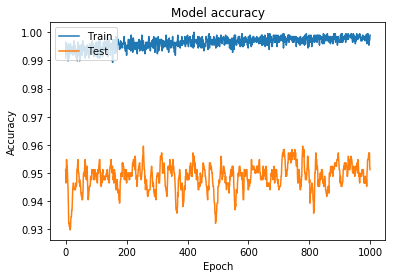

In [13]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [14]:
LDT_Net.save_weights('weights/coarse_lite.h5')

# Calculate time (excute it twice, the first time initialize takes extra times)

In [25]:
import time
start_time = time.time()
y = LDT_Net.predict([X_0,X_1])
time.time() - start_time

0.3947288990020752

# Plot confusion matrix

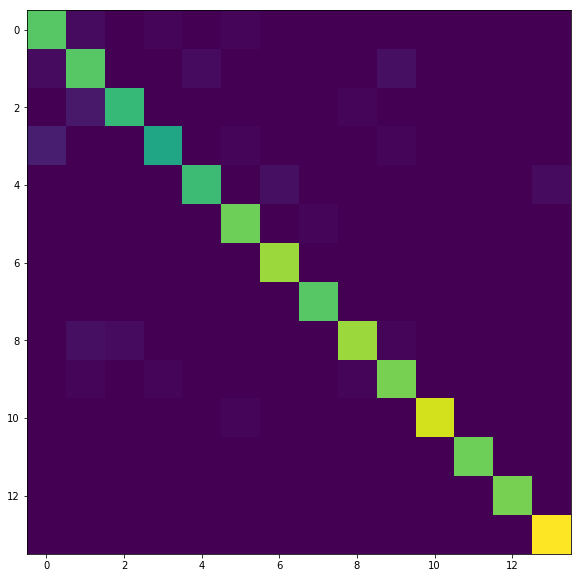

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

Y_pred = LDT_Net.predict([X_test_0,X_test_1])
cnf_matrix = confusion_matrix(np.argmax(Y_test,axis=1),np.argmax(Y_pred,axis=1))
plt.figure(figsize=(10,10))
plt.imshow(cnf_matrix)
plt.show()